<a href="https://colab.research.google.com/github/kupaqu/deeptable-gan/blob/main/8apr_DeepTable_GAN_softMax_csv_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [ ]:
!pip install torcheval
!pip install pymfe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.0/156.0 kB 989.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import math
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import init
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

import matplotlib.pyplot as plt
import pandas as pd
from pymfe.mfe import MFE
from tqdm import tqdm
from scipy.io import arff

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


# Датасет

In [ ]:
!unzip -qq /content/drive/MyDrive/31jan_data/csv.zip -d /content/data
!cp /content/drive/MyDrive/31jan_data/test.txt /content/data

In [ ]:
def fit_evaluate(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

@ignore_warnings(category=ConvergenceWarning)
def get_lambda(X, y, clfs=None):
    if clfs is None:
        clfs = [LogisticRegression(max_iter=1000), GaussianNB(), RandomForestClassifier()]
    scores = np.array([fit_evaluate(clf, X, y) for clf in clfs])
    lambda_ = np.exp(scores)/sum(np.exp(scores)) # softmax

    return lambda_

def get_meta(X, y):
    X = np.array(X)
    y = np.array(y)

    # mfe = MFE(groups=["general", "statistical", "info-theory", "model-based"])
    mfe = MFE(groups=["model-based"])
    mfe.fit(X, y, suppress_warnings=True)
    ft = np.array(mfe.extract()[1])
    ft[np.isnan(ft)] = 0

    scaler = MinMaxScaler()

    return scaler.fit_transform(ft.reshape(-1, 1)).flatten()

def get_binary_clf_datasets(dirs):
    Xs, ys, lambdas, metas = [], [], [], []

    for dir in tqdm(dirs):
        try:

            zero = pd.read_csv(os.path.join(dir, 'zero.csv'), header=None)
            one = pd.read_csv(os.path.join(dir, 'one.csv'), header=None)

            X = torch.tensor(pd.concat([zero, one], axis=0).values, dtype=torch.float32)
            y = torch.cat((torch.zeros((len(zero),)), torch.ones((len(one),))), dim=0)
            lambda_ = torch.tensor(get_lambda(X, y), dtype=torch.float32)
            meta = torch.tensor(get_meta(X, y), dtype=torch.float32)

            Xs.append(X)
            ys.append(y)
            lambdas.append(lambda_)
            metas.append(meta)
        except:
            continue

    return Xs, ys, lambdas, metas

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def get_batch_lambda(X, y, clfs=None):
    X, y = X.detach().numpy(), y.detach().numpy()
    X = X.reshape(-1, 16, 128)
    X = np.transpose(X, (0, 2, 1))
    y = y.reshape(-1, 128)

    lambdas = np.zeros((X.shape[0], 3))
    for i in range(X.shape[0]):
        if clfs is None:
            clfs = [LogisticRegression(max_iter=1000), GaussianNB(), RandomForestClassifier()]
        scores = np.array([fit_evaluate(clone(clf), X[i], y[i]) for clf in clfs])
        lambda_ = np.exp(scores)/sum(np.exp(scores))

        lambdas[i] = lambda_

    return torch.tensor(lambdas, dtype=torch.float32)

def get_batch_metas(Xs, ys, n_metas):
    Xs = Xs.cpu().detach().numpy()
    Xs = Xs.reshape(-1, 16, 128)
    Xs = np.transpose(Xs, (0, 2, 1))

    ys = ys.cpu().detach().numpy()
    ys = ys.reshape(-1, 128)

    metas = np.zeros((Xs.shape[0], n_metas))
    for i in range(Xs.shape[0]):
        X = Xs[i]
        y = ys[i]
        metas[i] = get_meta(X, y)

    return torch.tensor(metas, dtype=torch.float32)

class OpenMLDataset(torch.utils.data.Dataset):
    def __init__(self, Xs, ys, lambdas, metas):
        self.Xs = Xs,
        self.ys = ys,
        self.lambdas = lambdas,
        self.metas = metas

    def __len__(self):
        return len(self.Xs[0])

    def __getitem__(self, idx):
        X = torch.permute(self.Xs[0][idx], (1, 0)) # первое измерение должно быть столбцами
        y = self.ys[0][idx]
        lambda_ = self.lambdas[0][idx]
        meta = self.metas[idx]

        return X, y, lambda_, meta

# DeepSets

In [ ]:
r"""
Permutation Equivariant and Permutation Invariant layers, as described in the
paper Deep Sets, by Zaheer et al. (https://arxiv.org/abs/1703.06114)
"""
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max', 'min'],  \
            '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)
        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M, dtype=torch.bool).to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta)/sizes

        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)


class EquivLinear(InvLinear):
    r"""Permutation equivariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(EquivLinear, self).__init__(in_features, out_features,
                                          bias=bias, reduction=reduction)

        self.alpha = nn.Parameter(torch.Tensor(self.in_features,
                                               self.out_features))

        self.reset_parameters()

    def reset_parameters(self):
        super(EquivLinear, self).reset_parameters()
        if hasattr(self, 'alpha'):
            init.xavier_uniform_(self.alpha)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to the output set
        Y = {y_1, ..., y_M} through a permutation equivariant linear transformation
        of the form:
            $y_i = \alpha x_i + \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N sets of same cardinality as in X where each element has dimension
           out_features (tensor with shape (N, M, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        Y = torch.zeros(N, M, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M, dtype=torch.bool).to(device)

        Y = torch.zeros(N, M, self.out_features).to(device)
        h_inv = super(EquivLinear, self).forward(X, mask=mask)
        Y[mask] = (X @ self.alpha + h_inv.unsqueeze(1))[mask]

        return Y

# Модель

In [ ]:
class DeepTable(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.equiv_0 = EquivLinear(1, 64)
        self.inv_0 = InvLinear(64, 128)
        self.equiv_1 = EquivLinear(128, 256)
        self.inv_1 = InvLinear(256, 512)

    def forward(self, x):

        N = x.shape[1] # количество столбцов в таблице
        x = x.unsqueeze(-1) # (batch_size, N, M, 1)
        x = x.flatten(0, 1) # (batch_size * N, M, 1)

        x = self.equiv_0(x) # (batch_size * N, M, 64)
        x = F.relu(x)
        x = self.inv_0(x) # (batch_size * N, 128)
        x = x.reshape(-1, N, 128) # (batch_size, N, 128)

        x = self.equiv_1(x) # (batch_size, N, 256)
        x = F.relu(x)
        x = self.inv_1(x) # (batch_size, 512)

        return x

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, n_clfs=3, n_metas=24):
        super().__init__()
        self.deeptable = DeepTable()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, n_clfs),
        )
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(512+n_metas, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x, meta):
        features = self.deeptable(x)
        lambda_ = self.classifier(features)

        concat = torch.cat((features, meta), 1)
        label = self.discriminator(concat) # метка датасета (реальный он или сгенерирован генеративной моделью)

        return lambda_, label

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, n_metas):
        super().__init__()
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32+n_metas, 64, kernel_size=(4, 7)), # не добавляем паддинг и страйд т. к. делит на классы
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 128, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 32, kernel_size=(4, 7), stride=(1, 2), padding=(0, 2)),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(32, 1, kernel_size=(4, 8), stride=(1, 2), padding=(0, 2))
        )

    def forward(self, x, meta):
        concat = torch.cat((x, meta), 1)
        return self.upconv(concat)

# Train loooop

In [ ]:
def train_d(d, g, opt, real_tables, real_target_lambdas, real_metas, n_metas, device='cpu'):
    alpha = 0.5
    opt.zero_grad()
    batch_size = real_tables.size(0)
    real_tables = real_tables.to(device)
    real_metas_d = real_metas.to(device)
    real_metas_g = real_metas_d.view(batch_size, n_metas, 1, 1)

    # реальные таблицы
    real_pred_lambdas, real_pred_labels = d(real_tables, real_metas_d)
    real_target_labels = torch.ones(batch_size, 1, device=device)

    # real_clf_loss = nn.functional.cross_entropy(real_pred_lambdas, real_target_lambdas) # TODO: поменять на L1
    real_clf_loss = nn.functional.l1_loss(real_pred_lambdas, real_target_lambdas)
    real_d_loss = nn.functional.binary_cross_entropy(real_pred_labels, real_target_labels)
    real_loss = alpha*real_clf_loss + real_d_loss

    # фейковые таблицы
    z = torch.randn(batch_size, 32, 1, 1, device=device)
    # fake_tables = g(z).view_as(real_tables)
    fake_tables = g(z, real_metas_g).view(-1, 16, 128)
    fake_y = torch.cat((torch.zeros((batch_size, 64)), torch.ones((batch_size, 64))), dim=1).to(device)
    fake_target_lambdas = get_batch_lambda(fake_tables.to('cpu'), fake_y.to('cpu')).to(device)

    fake_pred_lambdas, fake_pred_labels = d(fake_tables, real_metas_d)
    fake_target_labels = torch.zeros(batch_size, 1, device=device)

    # fake_clf_loss = nn.functional.cross_entropy(fake_pred_lambdas, fake_target_lambdas) # TODO: поменять на L1
    fake_clf_loss = nn.functional.l1_loss(real_pred_lambdas, real_target_lambdas)
    fake_d_loss = nn.functional.binary_cross_entropy(fake_pred_labels, fake_target_labels)
    fake_loss = alpha*fake_clf_loss + fake_d_loss

    # обновление весов
    loss = real_loss + fake_loss
    loss.backward()
    opt.step()

    return loss.item()

def train_g(d, g, opt, real_tables, real_metas, n_metas, device='cpu'):
    opt.zero_grad()
    batch_size = real_tables.size(0)

    # генерация
    latent = torch.randn(batch_size, 32, 1, 1, device=device)
    # fake_tables = g(latent).view_as(real_tables)
    real_metas_d = real_metas.to(device)
    real_metas_g = real_metas_d.view(batch_size, n_metas, 1, 1)
    fake_tables = g(latent, real_metas_g).view(-1, 16, 128)
    fake_y = torch.cat((torch.zeros((batch_size, 64)), torch.ones((batch_size, 64))), dim=1).to(device)

    # предсказания дискриминатора
    lambdas, labels = d(fake_tables, real_metas_d)
    targets = torch.ones(batch_size, 1, device=device)

    bce_loss = nn.functional.binary_cross_entropy(labels, targets)

    # сравнение метафичей
    fake_metas = get_batch_metas(fake_tables, fake_y, n_metas).to(device)
    # meta_loss = nn.functional.l1_loss(fake_metas, real_metas)

    loss = bce_loss # + meta_loss
    loss.backward()
    opt.step()

    return loss.item()

def batch_accuracy_and_f1_macro(pred, target):
    batch_size = pred.size(0)

    pred_ids = pred.cpu().argmax(dim=1, keepdim=False)
    target_ids = target.cpu().argmax(dim=1, keepdim=False)

    acc = multiclass_accuracy(pred_ids, target_ids)
    f1_macro = multiclass_f1_score(pred_ids, target_ids, num_classes=3, average='macro')

    return acc, f1_macro

def eval_d(d, g, tables, target_lambdas, metas, device='cpu'):
    tables = tables.to(device)
    metas = metas.to(device)
    pred_lambdas, pred_labels = d(tables, metas)
    clf_accuracy, clf_f1_macro = batch_accuracy_and_f1_macro(pred_lambdas, target_lambdas)
    clf_mae = torch.nn.functional.l1_loss(pred_lambdas.cpu(), target_lambdas.cpu())

    return clf_accuracy, clf_f1_macro, clf_mae

def train_gan(d, g, d_opt, g_opt, real_tables, real_target_lambdas, real_metas, n_metas, device='cpu'):
    d_loss = train_d(d, g, d_opt, real_tables, real_target_lambdas, real_metas, n_metas, device)
    g_loss = train_g(d, g, g_opt, real_tables, real_metas, n_metas, device)

    return d_loss, g_loss

def train_epoch(d, g, d_opt, g_opt, train_dataloader, val_dataloader, n_metas, device='cpu'):
    running_d_loss, running_g_loss = 0., 0.
    real_running_lambda_accuracy, real_running_lambda_f1_macro, real_running_lambda_mae = 0., 0., 0.
    fake_running_lambda_accuracy, fake_running_lambda_f1_macro, fake_running_lambda_mae = 0., 0., 0.
    val_running_lambda_accuracy, val_running_lambda_f1_macro, val_running_lambda_mae = 0., 0., 0.

    train_running_meta_mae = 0.
    val_running_meta_mae = 0.

    for X, y, lambda_, meta in tqdm(train_dataloader):
        X = X.to(device)
        lambda_ = lambda_.to(device)
        meta = meta.to(device)
        d_loss, g_loss = train_gan(d, g, d_opt, g_opt, X, lambda_, meta, n_metas, device=device)
        running_d_loss += d_loss
        running_g_loss += g_loss

        with torch.no_grad():
            z = torch.randn(X.size(0), 32, 1, 1, device=device)
            # fake_tables = g(z).view_as(X)
            meta_g = meta.view(X.size(0), n_metas, 1, 1) # изначальные метафичи
            fake_tables = g(z, meta_g).view(-1, 16, 128)
            fake_y = torch.cat((torch.zeros((X.size(0), 64)), torch.ones((X.size(0), 64))), dim=1).to(device)
            fake_target_lambdas = get_batch_lambda(fake_tables.to('cpu'), fake_y.to('cpu')).to(device)

            fake_metas = get_batch_metas(fake_tables, fake_y, n_metas) # полученные метафичи
            train_running_meta_mae += torch.nn.functional.l1_loss(fake_metas.to('cpu'), meta.to('cpu'))

            real_lambda_accuracy, real_lambda_f1_macro, real_lambda_mae = eval_d(d, g, X, lambda_, meta, device)
            fake_lambda_accuracy, fake_lambda_f1_macro, fake_lambda_mae = eval_d(d, g, fake_tables, fake_target_lambdas, meta, device)

            real_running_lambda_accuracy += real_lambda_accuracy
            real_running_lambda_f1_macro += real_lambda_f1_macro
            real_running_lambda_mae += real_lambda_mae
            fake_running_lambda_accuracy += fake_lambda_accuracy
            fake_running_lambda_f1_macro += fake_lambda_f1_macro
            fake_running_lambda_mae += fake_lambda_mae

    with torch.no_grad():
        for X, y, lambda_, meta in val_dataloader:
            z = torch.randn(X.size(0), 32, 1, 1, device=device)
            meta_g = meta.view(X.size(0), n_metas, 1, 1) # изначальные метафичи
            meta_g = meta_g.to(device)
            fake_tables = g(z, meta_g).view(-1, 16, 128)
            fake_y = torch.cat((torch.zeros((X.size(0), 64)), torch.ones((X.size(0), 64))), dim=1).to(device)
            fake_metas = get_batch_metas(fake_tables, fake_y, n_metas)
            val_running_meta_mae += torch.nn.functional.l1_loss(fake_metas.to('cpu'), meta.to('cpu'))

            val_lambda_accuracy, val_lambda_f1_macro, val_lambda_mae = eval_d(d, g, X, lambda_, meta, device)
            val_running_lambda_accuracy += val_lambda_accuracy
            val_running_lambda_f1_macro += val_lambda_f1_macro
            val_running_lambda_mae += val_lambda_mae

    n_train = len(train_dataloader)
    n_val = len(val_dataloader)

    return {
        'd_loss': running_d_loss / n_train,
        'g_loss': running_g_loss / n_train,

        'real_lambda_accuracy': real_running_lambda_accuracy.item() / n_train,
        'real_lambda_f1_macro': real_running_lambda_f1_macro.item() / n_train,
        'real_lambda_mae': real_running_lambda_mae.item() / n_train,

        'fake_lambda_accuracy': fake_running_lambda_accuracy.item() / n_train,
        'fake_lambda_f1_macro': fake_running_lambda_f1_macro.item() / n_train,
        'fake_lambda_mae': fake_running_lambda_mae.item() / n_train,

        'val_lambda_accuracy': val_running_lambda_accuracy.item() / n_val,
        'val_lambda_f1_macro': val_running_lambda_f1_macro.item() / n_val,
        'val_lambda_mae': val_running_lambda_mae.item() / n_val,

        'train_meta_mae': train_running_meta_mae.item() / n_train,
        'val_meta_mae': val_running_meta_mae.item() / n_val
    }

# Обучение

In [ ]:
def get_dataloader(batch_size=64):
    val_dirs = []
    with open('/content/data/test.txt', 'r') as f:
        for line in f.readlines():
            val_dirs.append(os.path.join('/content/data/', line[:-1]))

    train_dirs = []
    for dir in os.listdir('/content/data/'):
        if dir.endswith('.txt'):
            continue
        train_dir = os.path.join('/content/data/', dir)
        if train_dir in val_dirs:
            continue
        train_dirs.append(train_dir)

    print()
    print(f'Train dirs: {len(train_dirs)}, val dirs: {len(val_dirs)}')

    Xs_train, ys_train, lambdas_train, metas_train = get_binary_clf_datasets(train_dirs)
    Xs_val, ys_val, lambdas_val, metas_val = get_binary_clf_datasets(val_dirs)

    train_dataset = OpenMLDataset(Xs_train, ys_train, lambdas_train, metas_train)
    val_dataset = OpenMLDataset(Xs_val, ys_val, lambdas_val, metas_val)

    print()
    print(f'Train size: {len(train_dataset)}, val size: {len(val_dataset)})')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader

In [ ]:
def plot_history(history):
    d_losses = [history[i]['d_loss'] for i in range(len(history))]
    g_losses = [history[i]['g_loss'] for i in range(len(history))]
    plt.plot(d_losses)
    plt.plot(g_losses)
    plt.title('GAN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['d_loss', 'g_loss'], loc='upper left')
    plt.show()

    real_lambda_accuracies = [history[i]['real_lambda_accuracy'] for i in range(len(history))]
    fake_lambda_accuracies = [history[i]['fake_lambda_accuracy'] for i in range(len(history))]
    val_lambda_accuracies = [history[i]['val_lambda_accuracy'] for i in range(len(history))]
    plt.plot(real_lambda_accuracies)
    plt.plot(fake_lambda_accuracies)
    plt.plot(val_lambda_accuracies)
    plt.title('Lambda classifier accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_accuracy', 'fake_lambda_accuracy', 'val_lambda_accuracy'], loc='upper left')
    plt.show()

    real_lambda_f1_macros = [history[i]['real_lambda_f1_macro'] for i in range(len(history))]
    fake_lambda_f1_macros = [history[i]['fake_lambda_f1_macro'] for i in range(len(history))]
    val_lambda_f1_macros = [history[i]['val_lambda_f1_macro'] for i in range(len(history))]
    plt.plot(real_lambda_f1_macros)
    plt.plot(fake_lambda_f1_macros)
    plt.plot(val_lambda_f1_macros)
    plt.title('Lambda classifier F1')
    plt.ylabel('F1 macro')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_f1_macro', 'fake_lambda_f1_macro', 'val_lambda_f1_macro'], loc='upper left')
    plt.show()

    real_lambda_mae = [history[i]['real_lambda_mae'] for i in range(len(history))]
    fake_lambda_mae = [history[i]['fake_lambda_mae'] for i in range(len(history))]
    val_lambda_mae = [history[i]['val_lambda_mae'] for i in range(len(history))]
    plt.plot(real_lambda_mae)
    plt.plot(fake_lambda_mae)
    plt.plot(val_lambda_mae)
    plt.title('Lambda classifier MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['real_lambda_mae', 'fake_lambda_mae', 'val_lambda_mae'], loc='upper left')
    plt.show()

    train_meta_mae = [history[i]['train_meta_mae'] for i in range(len(history))]
    val_meta_mae = [history[i]['val_meta_mae'] for i in range(len(history))]
    plt.plot(train_meta_mae)
    plt.plot(val_meta_mae)
    plt.title('Generator meta-features MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train_meta_mae', 'val_meta_mae'], loc='upper left')
    plt.show()

In [ ]:
train_dataloader, val_dataloader = get_dataloader(batch_size=64)


Train dirs: 8000, val dirs: 1911


100%|██████████| 1911/1911 [06:08<00:00,  5.19it/s]


Train size: 8000, val size: 1911)


In [ ]:
device = 'cuda'

d = Discriminator(3, 24).to(device)
g = Generator(24).to(device)

d_opt = torch.optim.Adam(d.parameters(), lr=0.0003)
g_opt = torch.optim.Adam(g.parameters(), lr=0.0003)

In [ ]:
n_metas = 24
history = []
for epoch in range(20):
    print(f'Epoch {epoch+1}:')
    history.append(train_epoch(d, g, d_opt, g_opt, train_dataloader, val_dataloader, n_metas, device=device))
    torch.save(d.state_dict(), f'/content/drive/MyDrive/DeepTable-models/d-{epoch+1}.pt')
    torch.save(g.state_dict(), f'/content/drive/MyDrive/DeepTable-models/g-{epoch+1}.pt')
    print(history[epoch])
    print()


Epoch 1:


100%|██████████| 125/125 [52:54<00:00, 25.40s/it]


{'d_loss': 1.4409089345932007, 'g_loss': 0.7210910573005677, 'real_lambda_accuracy': 0.357125, 'real_lambda_f1_macro': 0.304806640625, 'real_lambda_mae': 0.05615606689453125, 'fake_lambda_accuracy': 0.309, 'fake_lambda_f1_macro': 0.27140658569335935, 'fake_lambda_mae': 0.06800002288818359, 'val_lambda_accuracy': 0.32678976058959963, 'val_lambda_f1_macro': 0.2962968826293945, 'val_lambda_mae': 0.0346367081006368, 'train_meta_mae': 0.05369488525390625, 'val_meta_mae': 0.06955976486206054}

Epoch 2:


100%|██████████| 125/125 [51:22<00:00, 24.66s/it]


{'d_loss': 1.4172934236526489, 'g_loss': 0.6948285164833069, 'real_lambda_accuracy': 0.36775, 'real_lambda_f1_macro': 0.32882794189453124, 'real_lambda_mae': 0.031688589096069336, 'fake_lambda_accuracy': 0.348375, 'fake_lambda_f1_macro': 0.3010514221191406, 'fake_lambda_mae': 0.03801895904541015, 'val_lambda_accuracy': 0.36219698588053384, 'val_lambda_f1_macro': 0.31767441431681315, 'val_lambda_mae': 0.028899240493774413, 'train_meta_mae': 0.055671546936035154, 'val_meta_mae': 0.07336841424306234}

Epoch 3:


100%|██████████| 125/125 [51:23<00:00, 24.67s/it]


{'d_loss': 1.4135880365371705, 'g_loss': 0.7007851495742797, 'real_lambda_accuracy': 0.358375, 'real_lambda_f1_macro': 0.3214884338378906, 'real_lambda_mae': 0.02694768524169922, 'fake_lambda_accuracy': 0.376875, 'fake_lambda_f1_macro': 0.3333774108886719, 'fake_lambda_mae': 0.028866138458251953, 'val_lambda_accuracy': 0.3651609738667806, 'val_lambda_f1_macro': 0.30968844095865883, 'val_lambda_mae': 0.025005219380060832, 'train_meta_mae': 0.05570466613769531, 'val_meta_mae': 0.0646609385808309}

Epoch 4:


100%|██████████| 125/125 [51:46<00:00, 24.85s/it]


{'d_loss': 1.3991452808380127, 'g_loss': 0.7565405836105347, 'real_lambda_accuracy': 0.357375, 'real_lambda_f1_macro': 0.31444110107421874, 'real_lambda_mae': 0.024005355834960936, 'fake_lambda_accuracy': 0.370375, 'fake_lambda_f1_macro': 0.31703897094726563, 'fake_lambda_mae': 0.027340978622436524, 'val_lambda_accuracy': 0.35318180720011394, 'val_lambda_f1_macro': 0.3127629597981771, 'val_lambda_mae': 0.023684678475062053, 'train_meta_mae': 0.0559267692565918, 'val_meta_mae': 0.07554064591725668}

Epoch 5:


100%|██████████| 125/125 [51:30<00:00, 24.72s/it]


{'d_loss': 1.4093112878799439, 'g_loss': 0.7196822142601014, 'real_lambda_accuracy': 0.365, 'real_lambda_f1_macro': 0.32049276733398435, 'real_lambda_mae': 0.0219608211517334, 'fake_lambda_accuracy': 0.34025, 'fake_lambda_f1_macro': 0.3129234313964844, 'fake_lambda_mae': 0.025331462860107422, 'val_lambda_accuracy': 0.38955491383870444, 'val_lambda_f1_macro': 0.3056140899658203, 'val_lambda_mae': 0.020896496375401814, 'train_meta_mae': 0.06019064712524414, 'val_meta_mae': 0.07295757134755453}

Epoch 6:


100%|██████████| 125/125 [51:52<00:00, 24.90s/it]


{'d_loss': 1.4024144649505614, 'g_loss': 0.7322577986717224, 'real_lambda_accuracy': 0.36525, 'real_lambda_f1_macro': 0.31706829833984373, 'real_lambda_mae': 0.020162172317504883, 'fake_lambda_accuracy': 0.2865, 'fake_lambda_f1_macro': 0.2667535400390625, 'fake_lambda_mae': 0.02338123893737793, 'val_lambda_accuracy': 0.3816571871439616, 'val_lambda_f1_macro': 0.3222827911376953, 'val_lambda_mae': 0.01951982776323954, 'train_meta_mae': 0.06344026565551758, 'val_meta_mae': 0.0758009672164917}

Epoch 7:


100%|██████████| 125/125 [51:19<00:00, 24.63s/it]


{'d_loss': 1.389974838256836, 'g_loss': 0.8215172417163848, 'real_lambda_accuracy': 0.365375, 'real_lambda_f1_macro': 0.3192024841308594, 'real_lambda_mae': 0.019134489059448243, 'fake_lambda_accuracy': 0.272125, 'fake_lambda_f1_macro': 0.2505426025390625, 'fake_lambda_mae': 0.024821681976318358, 'val_lambda_accuracy': 0.36907196044921875, 'val_lambda_f1_macro': 0.3213337898254395, 'val_lambda_mae': 0.018050259351730345, 'train_meta_mae': 0.06379668045043946, 'val_meta_mae': 0.07746400038401285}

Epoch 8:


100%|██████████| 125/125 [53:02<00:00, 25.46s/it]


{'d_loss': 1.363752992630005, 'g_loss': 0.813579445362091, 'real_lambda_accuracy': 0.362, 'real_lambda_f1_macro': 0.3112453308105469, 'real_lambda_mae': 0.018023391723632813, 'fake_lambda_accuracy': 0.32475, 'fake_lambda_f1_macro': 0.28955548095703126, 'fake_lambda_mae': 0.022022010803222657, 'val_lambda_accuracy': 0.32427082061767576, 'val_lambda_f1_macro': 0.29625768661499025, 'val_lambda_mae': 0.01768368681271871, 'train_meta_mae': 0.06140539932250977, 'val_meta_mae': 0.0736779530843099}

Epoch 9:


100%|██████████| 125/125 [51:42<00:00, 24.82s/it]


{'d_loss': 1.3128012952804566, 'g_loss': 1.2541536340713502, 'real_lambda_accuracy': 0.35325, 'real_lambda_f1_macro': 0.29804129028320314, 'real_lambda_mae': 0.01778862380981445, 'fake_lambda_accuracy': 0.3285, 'fake_lambda_f1_macro': 0.2953641357421875, 'fake_lambda_mae': 0.022711034774780273, 'val_lambda_accuracy': 0.3589015007019043, 'val_lambda_f1_macro': 0.2867891311645508, 'val_lambda_mae': 0.01709558963775635, 'train_meta_mae': 0.06108420944213867, 'val_meta_mae': 0.07381226221720377}

Epoch 10:


100%|██████████| 125/125 [48:24<00:00, 23.24s/it]


{'d_loss': 1.41654408454895, 'g_loss': 0.8260630075931549, 'real_lambda_accuracy': 0.3685, 'real_lambda_f1_macro': 0.30836526489257815, 'real_lambda_mae': 0.016628822326660155, 'fake_lambda_accuracy': 0.335875, 'fake_lambda_f1_macro': 0.29610467529296874, 'fake_lambda_mae': 0.01982136535644531, 'val_lambda_accuracy': 0.4064678192138672, 'val_lambda_f1_macro': 0.3483363787333171, 'val_lambda_mae': 0.01596068541208903, 'train_meta_mae': 0.061857742309570314, 'val_meta_mae': 0.0739590326944987}

Epoch 11:


100%|██████████| 125/125 [48:09<00:00, 23.12s/it]


{'d_loss': 1.2865035314559936, 'g_loss': 0.7590871338844299, 'real_lambda_accuracy': 0.362, 'real_lambda_f1_macro': 0.2994647827148437, 'real_lambda_mae': 0.016009824752807617, 'fake_lambda_accuracy': 0.32, 'fake_lambda_f1_macro': 0.27555706787109374, 'fake_lambda_mae': 0.019104034423828124, 'val_lambda_accuracy': 0.39761365254720055, 'val_lambda_f1_macro': 0.3177843411763509, 'val_lambda_mae': 0.015502103169759114, 'train_meta_mae': 0.06254575729370117, 'val_meta_mae': 0.076046355565389}

Epoch 12:


100%|██████████| 125/125 [48:21<00:00, 23.21s/it]


{'d_loss': 1.3186977109909057, 'g_loss': 0.758909173488617, 'real_lambda_accuracy': 0.3675, 'real_lambda_f1_macro': 0.30884149169921876, 'real_lambda_mae': 0.01542958641052246, 'fake_lambda_accuracy': 0.332, 'fake_lambda_f1_macro': 0.290811279296875, 'fake_lambda_mae': 0.01860847282409668, 'val_lambda_accuracy': 0.3750568072001139, 'val_lambda_f1_macro': 0.30901416142781574, 'val_lambda_mae': 0.01492668092250824, 'train_meta_mae': 0.063689697265625, 'val_meta_mae': 0.07587936719258627}

Epoch 13:


100%|██████████| 125/125 [48:10<00:00, 23.13s/it]


{'d_loss': 1.0656130033731461, 'g_loss': 1.1713666806221008, 'real_lambda_accuracy': 0.365875, 'real_lambda_f1_macro': 0.29947494506835937, 'real_lambda_mae': 0.015029898643493652, 'fake_lambda_accuracy': 0.336375, 'fake_lambda_f1_macro': 0.27116970825195313, 'fake_lambda_mae': 0.01908430290222168, 'val_lambda_accuracy': 0.38104165395100914, 'val_lambda_f1_macro': 0.3029827435811361, 'val_lambda_mae': 0.014433492223421733, 'train_meta_mae': 0.06245925521850586, 'val_meta_mae': 0.07145260175069174}

Epoch 14:


100%|██████████| 125/125 [48:04<00:00, 23.08s/it]


{'d_loss': 0.8406449156999588, 'g_loss': 1.4085173406600953, 'real_lambda_accuracy': 0.3845, 'real_lambda_f1_macro': 0.3139017333984375, 'real_lambda_mae': 0.01472341537475586, 'fake_lambda_accuracy': 0.395375, 'fake_lambda_f1_macro': 0.27723193359375, 'fake_lambda_mae': 0.020163051605224608, 'val_lambda_accuracy': 0.42549241383870445, 'val_lambda_f1_macro': 0.3566584587097168, 'val_lambda_mae': 0.01421774725119273, 'train_meta_mae': 0.05674901580810547, 'val_meta_mae': 0.06905004183451334}

Epoch 15:


100%|██████████| 125/125 [48:17<00:00, 23.18s/it]


{'d_loss': 0.9730408668518067, 'g_loss': 1.0127624530792236, 'real_lambda_accuracy': 0.392625, 'real_lambda_f1_macro': 0.31415902709960936, 'real_lambda_mae': 0.014233842849731445, 'fake_lambda_accuracy': 0.39275, 'fake_lambda_f1_macro': 0.26959246826171873, 'fake_lambda_mae': 0.02118058204650879, 'val_lambda_accuracy': 0.36733900705973305, 'val_lambda_f1_macro': 0.3167954762776693, 'val_lambda_mae': 0.013822014133135477, 'train_meta_mae': 0.055139892578125, 'val_meta_mae': 0.06680150826772054}

Epoch 16:


100%|██████████| 125/125 [48:33<00:00, 23.31s/it]


{'d_loss': 0.9519868838787079, 'g_loss': 1.0439689559936522, 'real_lambda_accuracy': 0.403625, 'real_lambda_f1_macro': 0.31800811767578124, 'real_lambda_mae': 0.013850581169128419, 'fake_lambda_accuracy': 0.401625, 'fake_lambda_f1_macro': 0.2461333770751953, 'fake_lambda_mae': 0.020161664962768555, 'val_lambda_accuracy': 0.34294506708780925, 'val_lambda_f1_macro': 0.2439114570617676, 'val_lambda_mae': 0.012946040431658427, 'train_meta_mae': 0.05591614532470703, 'val_meta_mae': 0.06713326772054036}

Epoch 17:


100%|██████████| 125/125 [48:35<00:00, 23.32s/it]


{'d_loss': 0.9848318300247192, 'g_loss': 1.1149219555854797, 'real_lambda_accuracy': 0.398625, 'real_lambda_f1_macro': 0.31414764404296874, 'real_lambda_mae': 0.013454980850219726, 'fake_lambda_accuracy': 0.507, 'fake_lambda_f1_macro': 0.27161642456054685, 'fake_lambda_mae': 0.019925788879394533, 'val_lambda_accuracy': 0.3863446871439616, 'val_lambda_f1_macro': 0.2999979337056478, 'val_lambda_mae': 0.012638286749521891, 'train_meta_mae': 0.05366486358642578, 'val_meta_mae': 0.06657185554504394}

Epoch 18:


100%|██████████| 125/125 [48:22<00:00, 23.22s/it]


{'d_loss': 0.927456672668457, 'g_loss': 1.1304566073417663, 'real_lambda_accuracy': 0.40375, 'real_lambda_f1_macro': 0.31021380615234373, 'real_lambda_mae': 0.013117533683776855, 'fake_lambda_accuracy': 0.5575, 'fake_lambda_f1_macro': 0.2825054321289063, 'fake_lambda_mae': 0.019588600158691405, 'val_lambda_accuracy': 0.3467613538106283, 'val_lambda_f1_macro': 0.2693373998006185, 'val_lambda_mae': 0.012293574213981629, 'train_meta_mae': 0.053900646209716796, 'val_meta_mae': 0.06657659610112508}

Epoch 19:


100%|██████████| 125/125 [47:57<00:00, 23.02s/it]


{'d_loss': 0.9754558906555176, 'g_loss': 1.1228342957496642, 'real_lambda_accuracy': 0.40575, 'real_lambda_f1_macro': 0.3079933471679687, 'real_lambda_mae': 0.012885207176208497, 'fake_lambda_accuracy': 0.60525, 'fake_lambda_f1_macro': 0.28742864990234374, 'fake_lambda_mae': 0.01945745086669922, 'val_lambda_accuracy': 0.42217801411946615, 'val_lambda_f1_macro': 0.3237277030944824, 'val_lambda_mae': 0.012116302053133647, 'train_meta_mae': 0.05254547119140625, 'val_meta_mae': 0.06467804114023844}

Epoch 20:


100%|██████████| 125/125 [47:41<00:00, 22.89s/it]


{'d_loss': 0.9541809649467469, 'g_loss': 1.0728972454071044, 'real_lambda_accuracy': 0.409625, 'real_lambda_f1_macro': 0.3131722412109375, 'real_lambda_mae': 0.012604358673095704, 'fake_lambda_accuracy': 0.635625, 'fake_lambda_f1_macro': 0.29361572265625, 'fake_lambda_mae': 0.01982400321960449, 'val_lambda_accuracy': 0.34025567372639975, 'val_lambda_f1_macro': 0.24750070571899413, 'val_lambda_mae': 0.011838842431704204, 'train_meta_mae': 0.05266087341308594, 'val_meta_mae': 0.06337066888809204}



In [ ]:
plot_history(history)

NameError: name 'history' is not defined

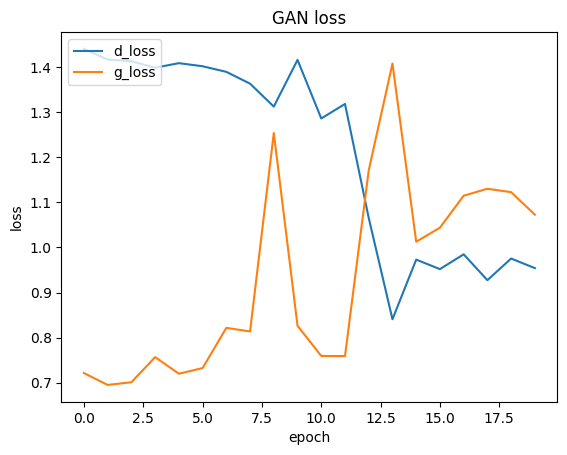

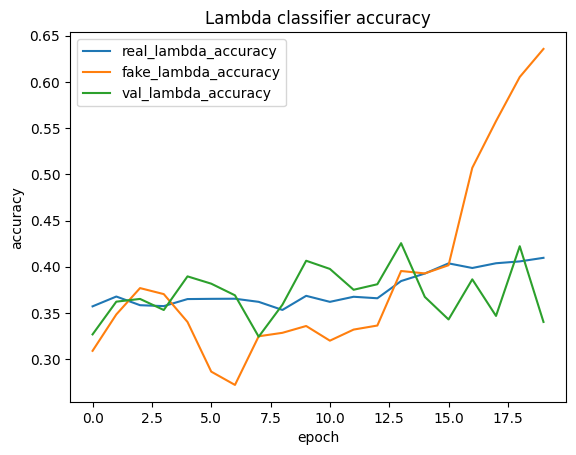

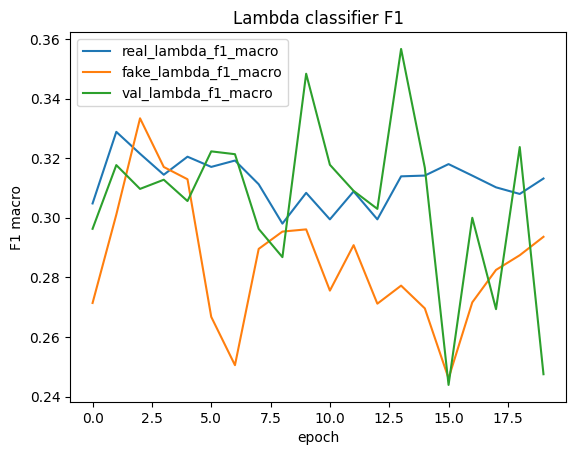

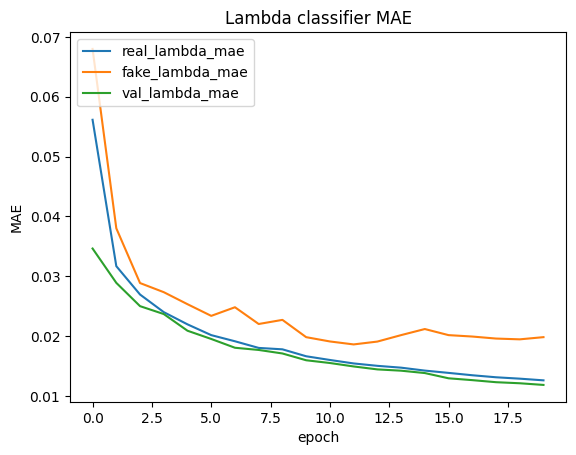

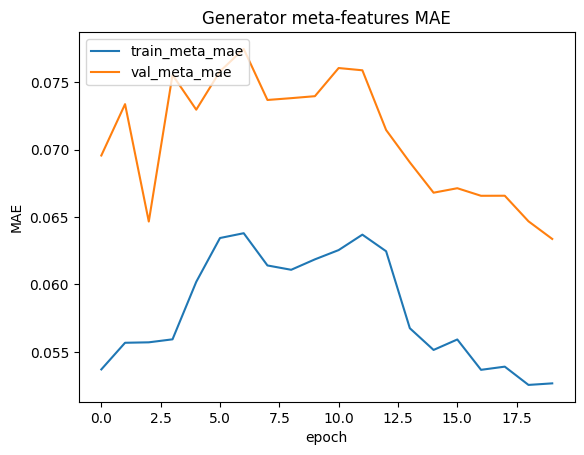

In [ ]:
plot_history([
    {'d_loss': 1.4409089345932007, 'g_loss': 0.7210910573005677, 'real_lambda_accuracy': 0.357125, 'real_lambda_f1_macro': 0.304806640625, 'real_lambda_mae': 0.05615606689453125, 'fake_lambda_accuracy': 0.309, 'fake_lambda_f1_macro': 0.27140658569335935, 'fake_lambda_mae': 0.06800002288818359, 'val_lambda_accuracy': 0.32678976058959963, 'val_lambda_f1_macro': 0.2962968826293945, 'val_lambda_mae': 0.0346367081006368, 'train_meta_mae': 0.05369488525390625, 'val_meta_mae': 0.06955976486206054},
    {'d_loss': 1.4172934236526489, 'g_loss': 0.6948285164833069, 'real_lambda_accuracy': 0.36775, 'real_lambda_f1_macro': 0.32882794189453124, 'real_lambda_mae': 0.031688589096069336, 'fake_lambda_accuracy': 0.348375, 'fake_lambda_f1_macro': 0.3010514221191406, 'fake_lambda_mae': 0.03801895904541015, 'val_lambda_accuracy': 0.36219698588053384, 'val_lambda_f1_macro': 0.31767441431681315, 'val_lambda_mae': 0.028899240493774413, 'train_meta_mae': 0.055671546936035154, 'val_meta_mae': 0.07336841424306234},
    {'d_loss': 1.4135880365371705, 'g_loss': 0.7007851495742797, 'real_lambda_accuracy': 0.358375, 'real_lambda_f1_macro': 0.3214884338378906, 'real_lambda_mae': 0.02694768524169922, 'fake_lambda_accuracy': 0.376875, 'fake_lambda_f1_macro': 0.3333774108886719, 'fake_lambda_mae': 0.028866138458251953, 'val_lambda_accuracy': 0.3651609738667806, 'val_lambda_f1_macro': 0.30968844095865883, 'val_lambda_mae': 0.025005219380060832, 'train_meta_mae': 0.05570466613769531, 'val_meta_mae': 0.0646609385808309},
    {'d_loss': 1.3991452808380127, 'g_loss': 0.7565405836105347, 'real_lambda_accuracy': 0.357375, 'real_lambda_f1_macro': 0.31444110107421874, 'real_lambda_mae': 0.024005355834960936, 'fake_lambda_accuracy': 0.370375, 'fake_lambda_f1_macro': 0.31703897094726563, 'fake_lambda_mae': 0.027340978622436524, 'val_lambda_accuracy': 0.35318180720011394, 'val_lambda_f1_macro': 0.3127629597981771, 'val_lambda_mae': 0.023684678475062053, 'train_meta_mae': 0.0559267692565918, 'val_meta_mae': 0.07554064591725668},

    {'d_loss': 1.4093112878799439, 'g_loss': 0.7196822142601014, 'real_lambda_accuracy': 0.365, 'real_lambda_f1_macro': 0.32049276733398435, 'real_lambda_mae': 0.0219608211517334, 'fake_lambda_accuracy': 0.34025, 'fake_lambda_f1_macro': 0.3129234313964844, 'fake_lambda_mae': 0.025331462860107422, 'val_lambda_accuracy': 0.38955491383870444, 'val_lambda_f1_macro': 0.3056140899658203, 'val_lambda_mae': 0.020896496375401814, 'train_meta_mae': 0.06019064712524414, 'val_meta_mae': 0.07295757134755453},
    {'d_loss': 1.4024144649505614, 'g_loss': 0.7322577986717224, 'real_lambda_accuracy': 0.36525, 'real_lambda_f1_macro': 0.31706829833984373, 'real_lambda_mae': 0.020162172317504883, 'fake_lambda_accuracy': 0.2865, 'fake_lambda_f1_macro': 0.2667535400390625, 'fake_lambda_mae': 0.02338123893737793, 'val_lambda_accuracy': 0.3816571871439616, 'val_lambda_f1_macro': 0.3222827911376953, 'val_lambda_mae': 0.01951982776323954, 'train_meta_mae': 0.06344026565551758, 'val_meta_mae': 0.0758009672164917},
    {'d_loss': 1.389974838256836, 'g_loss': 0.8215172417163848, 'real_lambda_accuracy': 0.365375, 'real_lambda_f1_macro': 0.3192024841308594, 'real_lambda_mae': 0.019134489059448243, 'fake_lambda_accuracy': 0.272125, 'fake_lambda_f1_macro': 0.2505426025390625, 'fake_lambda_mae': 0.024821681976318358, 'val_lambda_accuracy': 0.36907196044921875, 'val_lambda_f1_macro': 0.3213337898254395, 'val_lambda_mae': 0.018050259351730345, 'train_meta_mae': 0.06379668045043946, 'val_meta_mae': 0.07746400038401285},
    {'d_loss': 1.363752992630005, 'g_loss': 0.813579445362091, 'real_lambda_accuracy': 0.362, 'real_lambda_f1_macro': 0.3112453308105469, 'real_lambda_mae': 0.018023391723632813, 'fake_lambda_accuracy': 0.32475, 'fake_lambda_f1_macro': 0.28955548095703126, 'fake_lambda_mae': 0.022022010803222657, 'val_lambda_accuracy': 0.32427082061767576, 'val_lambda_f1_macro': 0.29625768661499025, 'val_lambda_mae': 0.01768368681271871, 'train_meta_mae': 0.06140539932250977, 'val_meta_mae': 0.0736779530843099},

    {'d_loss': 1.3128012952804566, 'g_loss': 1.2541536340713502, 'real_lambda_accuracy': 0.35325, 'real_lambda_f1_macro': 0.29804129028320314, 'real_lambda_mae': 0.01778862380981445, 'fake_lambda_accuracy': 0.3285, 'fake_lambda_f1_macro': 0.2953641357421875, 'fake_lambda_mae': 0.022711034774780273, 'val_lambda_accuracy': 0.3589015007019043, 'val_lambda_f1_macro': 0.2867891311645508, 'val_lambda_mae': 0.01709558963775635, 'train_meta_mae': 0.06108420944213867, 'val_meta_mae': 0.07381226221720377},
    {'d_loss': 1.41654408454895, 'g_loss': 0.8260630075931549, 'real_lambda_accuracy': 0.3685, 'real_lambda_f1_macro': 0.30836526489257815, 'real_lambda_mae': 0.016628822326660155, 'fake_lambda_accuracy': 0.335875, 'fake_lambda_f1_macro': 0.29610467529296874, 'fake_lambda_mae': 0.01982136535644531, 'val_lambda_accuracy': 0.4064678192138672, 'val_lambda_f1_macro': 0.3483363787333171, 'val_lambda_mae': 0.01596068541208903, 'train_meta_mae': 0.061857742309570314, 'val_meta_mae': 0.0739590326944987},
    {'d_loss': 1.2865035314559936, 'g_loss': 0.7590871338844299, 'real_lambda_accuracy': 0.362, 'real_lambda_f1_macro': 0.2994647827148437, 'real_lambda_mae': 0.016009824752807617, 'fake_lambda_accuracy': 0.32, 'fake_lambda_f1_macro': 0.27555706787109374, 'fake_lambda_mae': 0.019104034423828124, 'val_lambda_accuracy': 0.39761365254720055, 'val_lambda_f1_macro': 0.3177843411763509, 'val_lambda_mae': 0.015502103169759114, 'train_meta_mae': 0.06254575729370117, 'val_meta_mae': 0.076046355565389},
    {'d_loss': 1.3186977109909057, 'g_loss': 0.758909173488617, 'real_lambda_accuracy': 0.3675, 'real_lambda_f1_macro': 0.30884149169921876, 'real_lambda_mae': 0.01542958641052246, 'fake_lambda_accuracy': 0.332, 'fake_lambda_f1_macro': 0.290811279296875, 'fake_lambda_mae': 0.01860847282409668, 'val_lambda_accuracy': 0.3750568072001139, 'val_lambda_f1_macro': 0.30901416142781574, 'val_lambda_mae': 0.01492668092250824, 'train_meta_mae': 0.063689697265625, 'val_meta_mae': 0.07587936719258627},

    {'d_loss': 1.0656130033731461, 'g_loss': 1.1713666806221008, 'real_lambda_accuracy': 0.365875, 'real_lambda_f1_macro': 0.29947494506835937, 'real_lambda_mae': 0.015029898643493652, 'fake_lambda_accuracy': 0.336375, 'fake_lambda_f1_macro': 0.27116970825195313, 'fake_lambda_mae': 0.01908430290222168, 'val_lambda_accuracy': 0.38104165395100914, 'val_lambda_f1_macro': 0.3029827435811361, 'val_lambda_mae': 0.014433492223421733, 'train_meta_mae': 0.06245925521850586, 'val_meta_mae': 0.07145260175069174},
    {'d_loss': 0.8406449156999588, 'g_loss': 1.4085173406600953, 'real_lambda_accuracy': 0.3845, 'real_lambda_f1_macro': 0.3139017333984375, 'real_lambda_mae': 0.01472341537475586, 'fake_lambda_accuracy': 0.395375, 'fake_lambda_f1_macro': 0.27723193359375, 'fake_lambda_mae': 0.020163051605224608, 'val_lambda_accuracy': 0.42549241383870445, 'val_lambda_f1_macro': 0.3566584587097168, 'val_lambda_mae': 0.01421774725119273, 'train_meta_mae': 0.05674901580810547, 'val_meta_mae': 0.06905004183451334},
    {'d_loss': 0.9730408668518067, 'g_loss': 1.0127624530792236, 'real_lambda_accuracy': 0.392625, 'real_lambda_f1_macro': 0.31415902709960936, 'real_lambda_mae': 0.014233842849731445, 'fake_lambda_accuracy': 0.39275, 'fake_lambda_f1_macro': 0.26959246826171873, 'fake_lambda_mae': 0.02118058204650879, 'val_lambda_accuracy': 0.36733900705973305, 'val_lambda_f1_macro': 0.3167954762776693, 'val_lambda_mae': 0.013822014133135477, 'train_meta_mae': 0.055139892578125, 'val_meta_mae': 0.06680150826772054},
    {'d_loss': 0.9519868838787079, 'g_loss': 1.0439689559936522, 'real_lambda_accuracy': 0.403625, 'real_lambda_f1_macro': 0.31800811767578124, 'real_lambda_mae': 0.013850581169128419, 'fake_lambda_accuracy': 0.401625, 'fake_lambda_f1_macro': 0.2461333770751953, 'fake_lambda_mae': 0.020161664962768555, 'val_lambda_accuracy': 0.34294506708780925, 'val_lambda_f1_macro': 0.2439114570617676, 'val_lambda_mae': 0.012946040431658427, 'train_meta_mae': 0.05591614532470703, 'val_meta_mae': 0.06713326772054036},

    {'d_loss': 0.9848318300247192, 'g_loss': 1.1149219555854797, 'real_lambda_accuracy': 0.398625, 'real_lambda_f1_macro': 0.31414764404296874, 'real_lambda_mae': 0.013454980850219726, 'fake_lambda_accuracy': 0.507, 'fake_lambda_f1_macro': 0.27161642456054685, 'fake_lambda_mae': 0.019925788879394533, 'val_lambda_accuracy': 0.3863446871439616, 'val_lambda_f1_macro': 0.2999979337056478, 'val_lambda_mae': 0.012638286749521891, 'train_meta_mae': 0.05366486358642578, 'val_meta_mae': 0.06657185554504394},
    {'d_loss': 0.927456672668457, 'g_loss': 1.1304566073417663, 'real_lambda_accuracy': 0.40375, 'real_lambda_f1_macro': 0.31021380615234373, 'real_lambda_mae': 0.013117533683776855, 'fake_lambda_accuracy': 0.5575, 'fake_lambda_f1_macro': 0.2825054321289063, 'fake_lambda_mae': 0.019588600158691405, 'val_lambda_accuracy': 0.3467613538106283, 'val_lambda_f1_macro': 0.2693373998006185, 'val_lambda_mae': 0.012293574213981629, 'train_meta_mae': 0.053900646209716796, 'val_meta_mae': 0.06657659610112508},
    {'d_loss': 0.9754558906555176, 'g_loss': 1.1228342957496642, 'real_lambda_accuracy': 0.40575, 'real_lambda_f1_macro': 0.3079933471679687, 'real_lambda_mae': 0.012885207176208497, 'fake_lambda_accuracy': 0.60525, 'fake_lambda_f1_macro': 0.28742864990234374, 'fake_lambda_mae': 0.01945745086669922, 'val_lambda_accuracy': 0.42217801411946615, 'val_lambda_f1_macro': 0.3237277030944824, 'val_lambda_mae': 0.012116302053133647, 'train_meta_mae': 0.05254547119140625, 'val_meta_mae': 0.06467804114023844},
    {'d_loss': 0.9541809649467469, 'g_loss': 1.0728972454071044, 'real_lambda_accuracy': 0.409625, 'real_lambda_f1_macro': 0.3131722412109375, 'real_lambda_mae': 0.012604358673095704, 'fake_lambda_accuracy': 0.635625, 'fake_lambda_f1_macro': 0.29361572265625, 'fake_lambda_mae': 0.01982400321960449, 'val_lambda_accuracy': 0.34025567372639975, 'val_lambda_f1_macro': 0.24750070571899413, 'val_lambda_mae': 0.011838842431704204, 'train_meta_mae': 0.05266087341308594, 'val_meta_mae': 0.06337066888809204}
])

In [ ]:
from torchsummary import summary

# summary(g, (35,1,1))

In [ ]:
summary(d, (16, 128))

In [ ]:
from sklearn.datasets import load_iris
data = load_iris()

In [ ]:
data['data'].shape